# RoboGarden ML Capstone Project - Credit Card Fraud Detection (Part C)

## Autoencoders.  

### Eight classifiers were tested in Part A.  Dataset analysis and visualization is included in Part A.  Reduced features and Undersampling is in Part B.  Dataset preparation will be duplicated but not explained.

## *This Project is the course completion submission for the RoboGarden Professional DataScience & Machine Learning Bootcamp.   July 2019*    

## *Objective:  Detect fraudulent credit card transactions based on transaction history.*

### *Note that with the autoencoder NN models, the fit process is not replicated on successive runs with the same inputs.  Thus some results for scores (area under the ROC & Precision-Recall curves and F1 score) vary slightly.  Re-running this notebook from the start did yield slightly different values than shown in the slide deck.

## Information:
Description: The dataset consists 284,807 credit card transactions made by European cardholders in September 2013

* Link: https://data.world/raghu543/credit-card-fraud-data

* File: creditcard.csv

* Features: 
    * Time (integer): transaction time (seconds since first transaction)  
    * V1 – V28 (decimal): results of PCA transformation  
    * Amount (decimal): transaction amount  
    * Class (T/F): fraudulent/genuine transaction (target)
* Notes:
    * Feature V1-V28 are the principal components obtained with PCA
    * The original features and background information about the data are not provided due to confidentiality issues
* License: Public domain (CC0)

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import livelossplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Load Data
dataset = pd.read_csv('creditcard.csv')

In [3]:
dataset.head()

time        v1        v2        v3        v4        v5        v6        v7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         v8        v9  ...       v21       v22       v23       v24       v25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        v26       v27       v28  amount  class  
0 -0.189115  0.133558 -0.021053  149.62  False  
1  0.125895 -0.008983  0.014724    2.69  False  
2 -0.139097 -0.055353 -0.059752  378.66  False  
3 -0.221929  0.062723  0.061458  123.50  False  
4  0.502292  0.219422  0.215153   69.99  False  

[5 rows x 31 columns]

In [4]:
dataset['class'].value_counts()

False    284315
True        492
Name: class, dtype: int64

In [5]:
# Drop Duplicates
df = dataset.drop_duplicates()
df['class'].value_counts()

False    283253
True        473
Name: class, dtype: int64

In [6]:
# ReIndex df so that there are no missing index values
df.index=range(df.shape[0])

## *Start with the complete set, drop the 'time' feature and split into train & test subsets and preserve the ratio of fraudulent samples in both using "stratify" in train_test_split.*  

In [7]:
y = df['class']
y.shape

(283726,)

In [8]:
dfx = df.drop(['time','class'], axis = 1)
dfx.shape

(283726, 29)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(dfx,y, stratify = y, test_size = 0.25, random_state = 6)

In [10]:
y_train.value_counts()

False    212439
True        355
Name: class, dtype: int64

In [11]:
y_test.value_counts()

False    70814
True       118
Name: class, dtype: int64

### Retain number of positives & negatives from train & test sets for use in calculating classification counts for changing decision thresholds.

In [12]:
N, P = y_test.value_counts()
Ntr, Ptr = y_train.value_counts()
N, P, Ntr, Ptr

(70814, 118, 212439, 355)

In [13]:
Test_Set = x_test  # Reserve a copy of x_test that is not scaled so that the actual amounts can be referenced

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### The test and train sets are complete and cover the entire population and are balanced with an equal proportion of fraud samples in each set.
#  

## Prepare functions for plots and reports

In [15]:
def Prob_Hist(model_name,probs):
    plt.figure(figsize=(12,4)) 
    sns.distplot(probs[:,1], bins = 100, color = 'tab:red', label = 'Sample Probability ', kde = False)
    plt.title((('Histogram of Prediction Probability for {}').format(model_name)), weight = 'bold', fontsize = 16)
    plt.xlabel('Classifier Probability', fontsize = 14)
    plt.ylabel( 'Log No. of Samples')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [16]:
def ROC_Plot(model_name, y_test, y_pred, probs, P, N):

    fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
    roc_auc = auc(fpr_, tpr_)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    plt.title((('{}\nReceiver Operating Characteristic').format(model_name)), weight = 'bold', fontsize = 16)
    plt.plot(fpr_, tpr_, 'purple', lw = '3', label='ROCAUC = %0.2f'% roc_auc)
    plt.scatter(fpr[1], tpr[1],s = 100, c = 'r', label = ('Conf. Matrix {:0.1e}, {:0.2f}').format(fpr[1], tpr[1]))
    plt.plot([0,1],[0,1],'r--')
    
    plt.legend(loc='lower right', fontsize = 14)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.0,1.01])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('True Positive Rate', weight = 'bold', fontsize = 14)
    plt.xlabel('False Positive Rate', weight = 'bold', fontsize = 14)
    plt.grid('black')

    return fpr_, tpr_, thresholds_

In [17]:
def PRC_Plot(model_name, y_test, y_pred, probs, P, N):

    precision_, recall_, _ = precision_recall_curve(y_test, probs[:,1])
    AP = average_precision_score(y_test, probs[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    single_pt_recall = tpr[1]
    single_pt_precision = (tpr[1]*P)/(tpr[1]*P + fpr[1]*N)
    
    plt.title((('{}\nPrecision - Recall Curve').format(model_name)), weight = 'bold', fontsize = 16)
    plt.step(recall_, precision_, 'blue', lw = '3', where = 'pre', label='au_prc = %0.2f'% AP)
    plt.scatter(single_pt_recall, single_pt_precision, s = 100, c = 'r', label = ('Conf. Matrix: {:0.2f}, {:0.2f}').format(single_pt_recall, single_pt_precision))
      
    plt.legend(loc='lower left', fontsize = 14)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.0,1.01])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('Precision', weight = 'bold', fontsize = 14)
    plt.xlabel('Recall', weight = 'bold', fontsize = 14)
    plt.grid('black')

    return

In [18]:
def Det_Amt_PLot(model_name, Test_set, y_test, y_pred):
    # Calculate the amount of fraud detected, missed, and false positive
    fraud_amount_IDd = Test_set

    fraud_amount_IDd['TP'] = 0
    fraud_amount_IDd['FP'] = 0
    fraud_amount_IDd['FN'] = 0
    
    fraud_amount_IDd['pred'] = y_pred
    fraud_amount_IDd['ytest'] = y_test
    
    fraud_amount_IDd['TP'] = fraud_amount_IDd['pred'] * fraud_amount_IDd['ytest']
    fraud_amount_IDd['FP'] = fraud_amount_IDd['pred'] * (fraud_amount_IDd['ytest'] == 0)
    fraud_amount_IDd['FN'] = (fraud_amount_IDd['pred'] == 0) * fraud_amount_IDd['ytest']

    fraud_amount_IDd['fraudIDd'] = fraud_amount_IDd['amount'] * fraud_amount_IDd['TP']
    fraud_amount_IDd['False_+ve'] = fraud_amount_IDd['amount'] *fraud_amount_IDd['FP']
    fraud_amount_IDd['fraud_notIDd'] = fraud_amount_IDd['amount'] * fraud_amount_IDd['FN']
    
    # PLot histogram of fraud detected, missed, and false positives
    plt.figure(figsize=(12,4))
    sns.distplot(fraud_amount_IDd['fraudIDd'][fraud_amount_IDd['TP'] == 1], bins = 40, color = 'tab:blue', label = 'Fraud Identified', kde = False) 
    sns.distplot(fraud_amount_IDd['fraud_notIDd'][fraud_amount_IDd['FN'] == 1], bins = 40, color = 'tab:orange', label = 'False -ve', kde = False)
    sns.distplot(fraud_amount_IDd['False_+ve'][fraud_amount_IDd['FP'] == 1], bins = 40, color = 'tab:red', label = 'False +ve', kde = False)
    
    plt.title((('Histogram of FP, TP, & FN Amounts for {}').format(model_name)), weight = 'bold', fontsize = 16)
    plt.xlabel('Amount', fontsize = 14)
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    # Print Sums
    fraudIDd = fraud_amount_IDd['fraudIDd'].sum()
    fraud_notIDd = fraud_amount_IDd['fraud_notIDd'].sum()
    false_pos_total = fraud_amount_IDd['False_+ve'].sum()
    print(('Fraud total identified is {:.{prec}f},\nFraud total missed is {:.{prec}f},\nNormal total misclassified is {:.{prec}f}').format(fraudIDd,fraud_notIDd, false_pos_total, prec = 2))

In [19]:
def Conf_Matrix(_title, cm):
    sns.set(font_scale=1.4)
    plt.title(('{}\n Confusion Matrix').format(_title))
    c_map = ['blue',  'orange']
    sns.heatmap(cm, cmap = c_map,  annot=True, fmt = 'g', annot_kws={"size": 24, "weight": 'bold'})
    plt.xlabel('Normal                  Fraud\nPredicted', fontsize = 16)
    plt.ylabel('Actual\n Fraud            Normal', fontsize = 16)
    
    return

In [20]:
# PLot for True Positive Counts vs. Decision Threshold
def FP_TP_Count_vs_Threshold(model_name, fpr_, tpr_, thresholds_, P, N, ylim, DT):
    plt.step(thresholds_, tpr_*P, c='blue', lw = '3', where = 'mid', label = 'True +ve')
    plt.step(thresholds_, fpr_*N, c='orange', lw = '3', where = 'mid', label = 'False +ve')
    plt.plot([DT,DT],[0,ylim], 'r--')
    plt.ylim(-0.01, ylim)
    plt.xlim(-0.01, 1.01)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(('{}\n FP & TP Count vs. Decision Threshold').format(model_name), weight = 'bold', fontsize = 16)
    plt.ylabel('FP Count, TP Count', weight = 'bold', fontsize=14)
    plt.xlabel('Classifier Decision Threshold', weight = 'bold', fontsize=14)
    plt.legend(loc='lower left', fontsize = 14)
    plt.grid('black')
    return


In [21]:
# Single Call for combined ROC & Precision-Recall Curve, plus False Positive / True Positive Counts vs. Decision Threshold
def ROC_Pre_Count_Plots_AE(title, Y, preds, probs, cm, P, N, MSE_TH):
       
    plt.figure(figsize=(12,6))
    gs0 = gridspec.GridSpec(1, 2)    
    ax1 = plt.subplot(gs0[0])    
    fpr_, tpr_, thresholds_ = ROC_Plot(title, Y, preds, probs, P, N)

    ax2 = plt.subplot(gs0[1])     
    PRC_Plot(title, Y, preds, probs, P, N)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,6))
    gs1 = gridspec.GridSpec(1, 2)   
    ax3 = plt.subplot(gs1[0])
    Conf_Matrix(title, cm)

    ax4 = plt.subplot(gs1[1])
    FP_TP_Count_vs_Threshold_AE(title, fpr_, tpr_, thresholds_, P, N, P+7, MSE_TH)
    plt.tight_layout()
    plt.show()

In [22]:
# Function to get reports from optimizations
def GetResults(title, clf, x_test, y_test, P, N, flag, DT): 
    if flag == 1:
        print(clf.best_estimator_.get_params())
    elif flag == 0:   
        print('model parameters: ',clf.get_params())
    else:
        print(' ')
    
    y_pred, probs = clf.predict(x_test),  clf.predict_proba(x_test)
    cm, AU_PRC = confusion_matrix(y_test, y_pred),  average_precision_score(y_test, probs[:,1])
    F1 = f1_score(y_test, y_pred)
    
    print(('\n{} gives AU_PRC of {:.3f}and F1 Score of {:.3f}\n').format(title, AU_PRC, F1))
    
    ROC_Pre_Count_Plots(title, y_test, y_pred, probs, cm, P, N, DT)

    return y_pred, probs, F1

In [23]:
def FP_TP_Count_Table(model_name, fpr_, tpr_, thresholds_, P, N, range_):
    print('{:^65}'.format('ROC Curve TP & FP Count by Classifier Decision Threshold:'))
    print(('{:^65}\n').format(model_name))
    print('-'*65)
    print(('{:>5}{:>12}{:>12}{:>12}{:>12}{:>12}').format('i', 'Threshold', 'TPR  ', 'TP Count', 'FPR   ', 'FP Count'))
    print('-'*65)
    for i in range(range_):        
        print(('{:>5}{:{width}.{prec}f}{:{width}.{prec}f}{:{width}.{prec2}f}{:{width}.{prec2}e}{:{width}.{prec2}f}').format(i, thresholds_[i], tpr_[i], tpr_[i]*P, fpr_[i], fpr_[i]*N, width =12, prec = 3, prec2 =1)) 

# *Fewer Features*

## Prepare a train & test set with the reduced number of features from Part B to first test the autoencoder process with a full set and reduced set of 10 features.  (v14, v17, v10, v12, v16, v11, v4, v3, v7, v9)

In [24]:
# Drop features keeping top 10 from feature importance result
dfx_10 = dfx.drop(['v1', 'v2', 'v5', 'v6', 'v8', 'v13', 'v15', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28'], axis = 1)
dfx_10.head()

v3        v4        v7        v9       v10       v11       v12  \
0  2.536347  1.378155  0.239599  0.363787  0.090794 -0.551600 -0.617801   
1  0.166480  0.448154 -0.078803 -0.255425 -0.166974  1.612727  1.065235   
2  1.773209  0.379780  0.791461 -1.514654  0.207643  0.624501  0.066084   
3  1.792993 -0.863291  0.237609 -1.387024 -0.054952 -0.226487  0.178228   
4  1.548718  0.403034  0.592941  0.817739  0.753074 -0.822843  0.538196   

        v14       v16       v17  amount  
0 -0.311169 -0.470401  0.207971  149.62  
1 -0.143772  0.463917 -0.114805    2.69  
2 -0.165946 -2.890083  1.109969  378.66  
3 -0.287924 -1.059647 -0.684093  123.50  
4 -1.119670 -0.451449 -0.237033   69.99

In [25]:
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(dfx_10, y, stratify = y, test_size = 0.25, random_state = 6)

In [26]:
#  Save a copy of train & test sets with amount before scaling to measure performance against amount identified
Test_Set_10 = x_test_10
Train_set_10 = x_train_10
x_train_10 =  x_train_10.iloc[:,0:10]
x_test_10 = x_test_10.iloc[:,0:10]
x_test_10[0:5][:]

v3        v4        v7        v9       v10       v11       v12  \
261092  1.083907  1.156584 -1.384707  2.577532 -0.398150 -1.030632  0.873628   
101269  0.585759  0.017661 -0.077298 -0.895438 -0.563033  0.840236  0.266429   
129533 -1.130026  0.471868  1.152082 -0.271176 -0.195106  0.956858  0.084526   
79561  -0.283318  3.033874  1.200761  0.136435 -0.207380 -0.988903 -0.537333   
233338 -0.218416  1.370863 -0.311308  0.856663  0.159186 -0.891397  0.411452   

             v14       v16       v17  
261092 -1.169164 -0.375988  0.462084  
101269  1.311771  0.428500 -0.130119  
129533  1.066976  0.350714 -0.434841  
79561   0.176618  1.101212 -0.371017  
233338  0.033599  0.337449 -0.640693

In [27]:
x_train_10 =  scaler.fit_transform(x_train_10)
x_test_10 = scaler.transform(x_test_10)

In [28]:
Ns, Ps = y_test_10.value_counts()
Ns, Ps

(70814, 118)

In [29]:
Ntrs, Ptrs = y_train_10.value_counts()
Ntrs, Ptrs

(212439, 355)

# *Autoencoders*

## Try Autoencoders using the reduced feature dataset

### Report functions

In [30]:
from time import time

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, f1_score

In [31]:
# Function to get MSE values and stats 
def AE_preds(title, AE, x_train, y_train, x_test, y_test, P, N, flag): 
    if flag == 1:
        print('Model Summary\n', AE.summary())
    
    #y_pred_train_normal = AE.predict(x_train[y_train == 0])
    #y_pred_train_fraud = AE.predict(x_train[y_train == 1])
    y_pred_train_all = AE.predict(x_train)

    y_pred_test_all = AE.predict(x_test)

    train_preds = np.empty((y_train.shape[0],1))
    for row in range(y_train.shape[0]):
        train_preds[row]=(mean_squared_error(x_train[row,:],y_pred_train_all[row,:]))
    
    test_preds = np.empty((y_test.shape[0],1))
    for row in range(y_test.shape[0]):
        test_preds[row]=(mean_squared_error(x_test[row,:],y_pred_test_all[row,:]))

    _min , _max, _mean, _std = min(train_preds),  max(train_preds), np.mean(train_preds), np.std(train_preds)
    
    return train_preds, test_preds, _min , _max, _mean, _std

In [32]:
# Plot histogram and scatter plots of MSE values
def Train_Hist_Scatter(train_preds, y_train, _min, _max, _mean, _std, ylim):
    print(('MSE stats for train set: min {:.4f}, max {:.4f}, mean {:.4f}, std {:.4f}').format(_min, _max, _mean, _std))
    
    plt.figure(figsize=(12,4)) 
    sns.distplot(test_preds, bins = 200, color = 'tab:blue', label = 'Autoencoders', kde = False)
    plt.title(('Histogram of Autoencoder MSE of Train Feature Difference'), weight = 'bold', fontsize = 16)
    plt.yscale('log')
    plt.show()

    plt.figure(figsize=(12,4)) 
    plt.title(('Autoencoder MSE of Train Feature Difference'), weight = 'bold', fontsize = 16)
    plt.scatter(x=range(len(y_train_10)), y=train_preds, c=y_train_10, cmap='tab10', alpha=0.7)
    plt.ylim(0,ylim)
    #plt.grid()    
    plt.show
    
    plt.figure(figsize=(12,4)) 
    plt.title(('Zoom of Autoencoder MSE of Train Feature Difference'), weight = 'bold', fontsize = 16)
    plt.scatter(x=range(len(y_train_10)), y=train_preds, c=y_train_10, cmap='tab10', alpha=0.7)
    plt.ylim(0,30)
    #plt.grid()    
    plt.show

In [33]:
# Get probabilities and true false for each sample.  Call plotting functions for reporting
from math import exp
def Probs_preds(title, Y, MSE_preds, P, N, MSE_TH):
    probs =np.empty((Y.shape[0],2))
    probs[:,1] = pd.Series(MSE_preds[:,0]).apply(lambda x: min(0.9999, np.log((x+1)**(1/3))/2))

    preds = np.empty((Y.shape[0],1))
    for row in range(Y.shape[0]):
        preds[row] = MSE_preds[row]>MSE_TH

    cm, AU_PRC = confusion_matrix(Y, preds),  average_precision_score(Y, probs[:,1])
    F1 = f1_score(Y, preds)
    
    print("MSE Decision Threshold is: ", MSE_TH)
    print(('\n{} gives AU_PRC of {:.3f}and F1 Score of {:.3f}\n').format(title, AU_PRC, F1))
     
    cm = confusion_matrix(Y, preds[:,0])
    
    ROC_Pre_Count_Plots_AE(title, Y, preds, probs, cm, P, N, MSE_TH)

    return probs, preds

In [34]:
# PLot for True Positive Counts vs. Decision Threshold
def FP_TP_Count_vs_Threshold_AE(title, fpr_, tpr_, thresholds_, P, N, ylim, MSE_TH):
    
    DT = np.log((MSE_TH+1)**(1/3))/2
    plt.step(thresholds_, tpr_*P, c='blue', lw = '3', where = 'mid', label = 'True +ve')
    plt.step(thresholds_, fpr_*N, c='orange', lw = '3', where = 'mid', label = 'False +ve')
    plt.plot([DT,DT],[0,ylim], 'r--')
    plt.ylim(-0.01, ylim)
    plt.xlim(-0.01, 1.01)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(('{}\n FP & TP Count vs. Classifier Decision Threshold').format(title), weight = 'bold', fontsize = 16)
    plt.ylabel('FP Count, TP Count', weight = 'bold', fontsize=14)
    plt.xlabel(('Classifier Decision Threshold, MSE = {}').format(MSE_TH), weight = 'bold', fontsize=14)
    plt.legend()
    plt.grid('black')
    return

In [35]:
#Import model libraries
from keras import Model, Sequential
from keras.callbacks import EarlyStopping
import livelossplot
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Begin modelling all 28 features plus Amount.

In [36]:
# Create Autoencoder Layers for 29 features & Compile
activ = 'softplus'
a = Input(shape=(29,))
b = Dense(20, activation = activ)(a)
c = Dense(10, activation = activ)(b)
d = Dense(5, activation = activ)(c)
e = Dense(5, activation = activ)(d)
f = Dense(10, activation = activ)(e)
g = Dense(20, activation = activ)(f)
Out = Dense(29, activation =activ)(g)
autoencoder29 = Model(inputs=a, outputs=Out)
autoencoder29.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

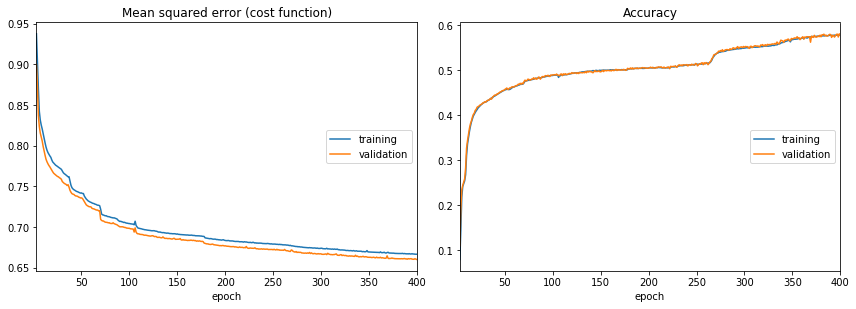

Mean squared error (cost function):
training   (min:    0.666, max:    1.153, cur:    0.666)
validation (min:    0.660, max:    0.943, cur:    0.660)

Accuracy:
training   (min:    0.019, max:    0.578, cur:    0.578)
validation (min:    0.027, max:    0.581, cur:    0.579)


In [38]:
autoencoder29.fit(x_train[y_train ==0], x_train[y_train ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

### Get the MSE of input vs output for each sample for the train and test sets, then plot the distribution, stats, and scatter plots of fraud & normal transactions.

In [39]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_29', autoencoder29, x_train, y_train, x_test, y_test, P, N, 0)

MSE stats for train set: min 0.0665, max 641.9530, mean 0.6989, std 2.9429


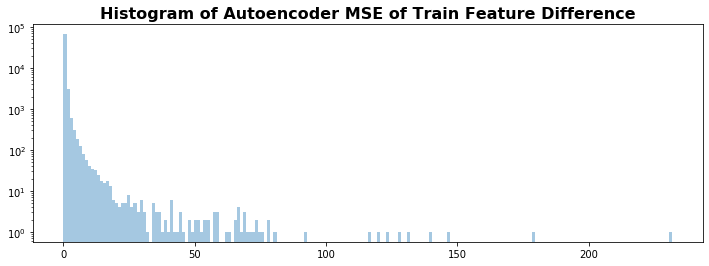

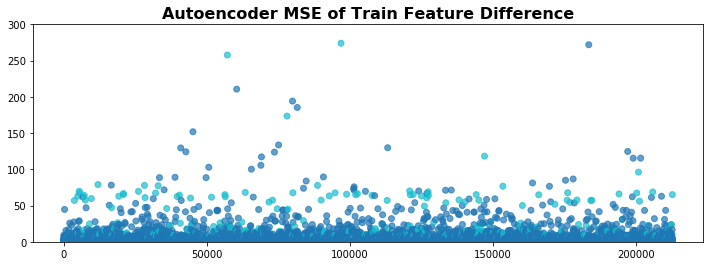

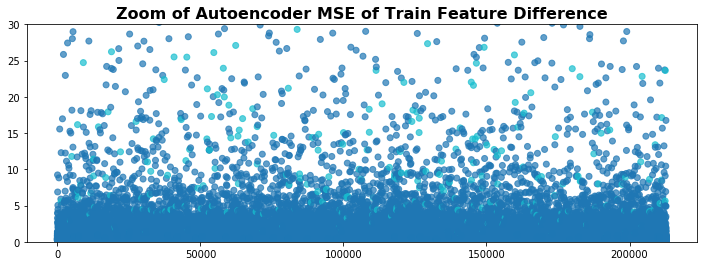

In [40]:
Train_Hist_Scatter(train_preds, y_train, _min[0], _max[0], _mean, _std, 300)

### Pick an MSE threshold to separate (vote on) frauds from normal transactions. Pick 50 and plot reultes for the training set and the test set (unseen data).

MSE Decision Threshold is:  50

Autoencoder 29 Features Training Results gives AU_PRC of 0.207and F1 Score of 0.279



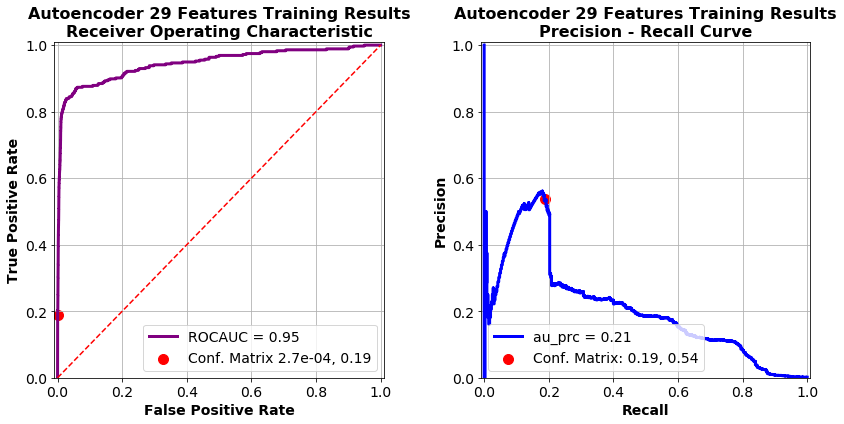

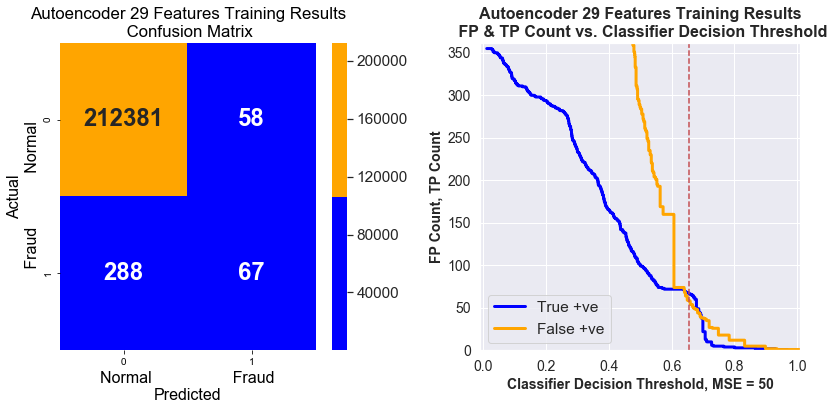

In [41]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs, y_train_preds = Probs_preds('Autoencoder 29 Features Training Results', y_train, train_preds, Ptr, Ntr, 50)

MSE Decision Threshold is:  50

Autoencoder 29 Features Test SetResults gives AU_PRC of 0.226and F1 Score of 0.303



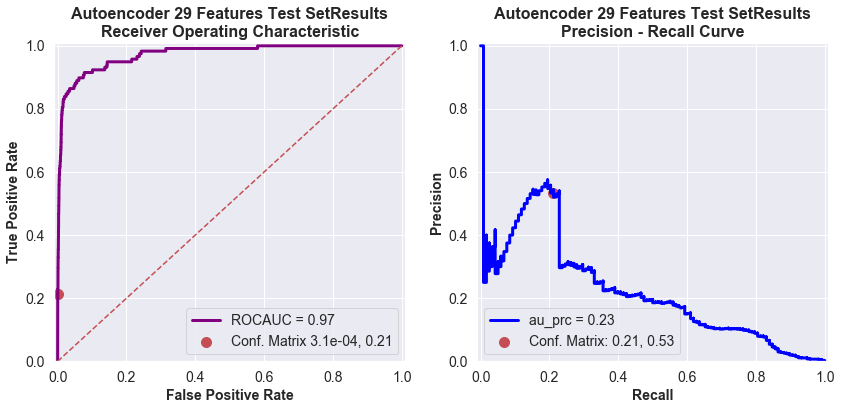

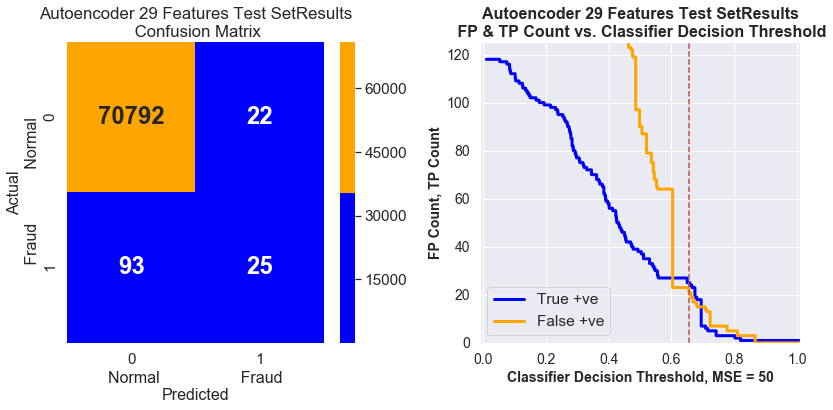

In [42]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs, y_test_preds = Probs_preds('Autoencoder 29 Features Test SetResults', y_test, test_preds, P, N, 50)

### The AU-PRC is poor.  Reduce the number of features and re-model.  Use the 10 feature subset previously used on Undersampling.  This does not include the Amount.

In [43]:
# Create Autoencoder Layers & Compile for 10 Features
activ = 'softplus'
a = Input(shape=(10,))
b = Dense(5, activation = activ)(a)
c = Dense(2, activation = activ)(b)
d = Dense(5, activation = activ)(c)
Out = Dense(10, activation =activ)(d)
autoencoder10 = Model(inputs=a, outputs=Out)
autoencoder10.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [44]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

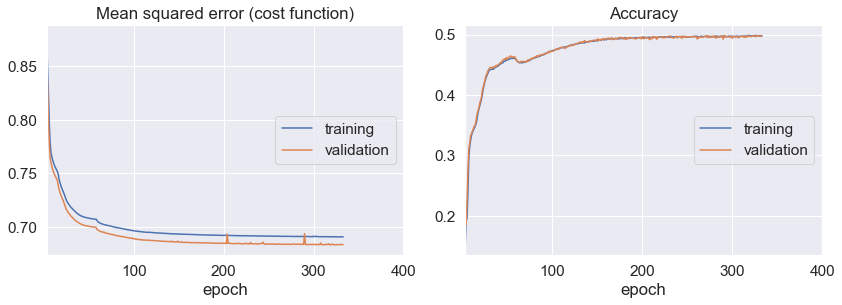

Mean squared error (cost function):
training   (min:    0.691, max:    1.179, cur:    0.691)
validation (min:    0.683, max:    0.995, cur:    0.683)

Accuracy:
training   (min:    0.077, max:    0.499, cur:    0.498)
validation (min:    0.092, max:    0.499, cur:    0.497)


In [45]:
#Fit the model, batch size, no. of epochs

autoencoder10.fit(x_train_10[y_train_10 ==0], x_train_10[y_train_10 ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

In [46]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_10', autoencoder10, x_train_10, y_train_10, x_test_10, y_test_10, Ps, Ns, 0)

### Plot Histogram and Scatter plot of sample MSE values (MSE of difference of original and reconstructed samples).

MSE stats for train set: min 0.0067, max 1160.2022, mean 0.7672, std 4.3052


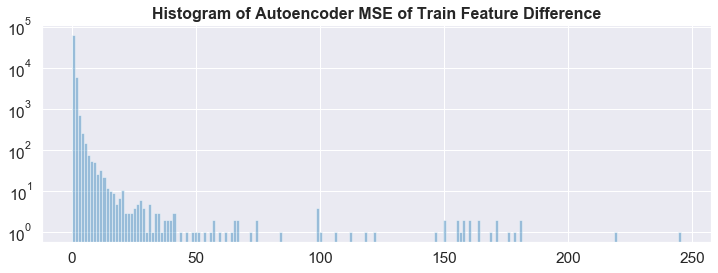

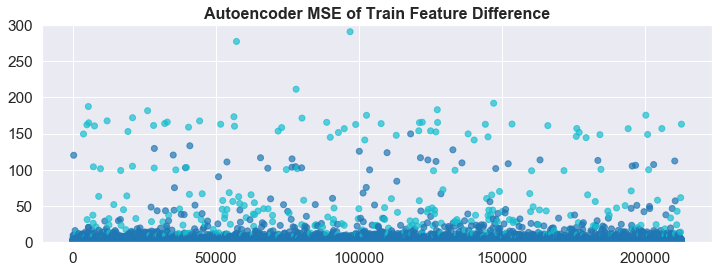

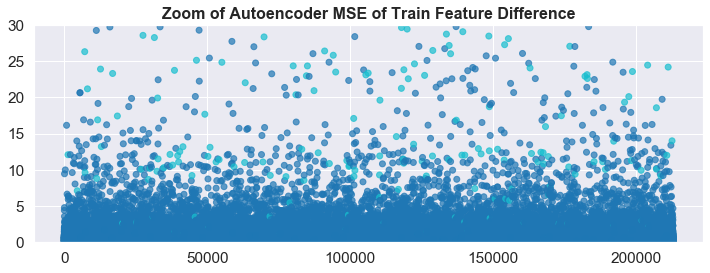

In [47]:
Train_Hist_Scatter(train_preds, y_train_10, _min[0], _max[0], _mean, _std, 300)

#### Zoom into the low end of the training data MSE plot to pick a threshold to correspond to a 50% confidence (>50% is designated fraud).  At about 20, there are roughly equal fraud and normal samples.  Below this the normal samples dominate and above, the fraud samples dominate.  Assume that the test set (or unknown data) will be similar.  Although the Autoencoder was trained with normal data only, the fraud cases are available to us to determine the threshold.  Picking 19 allows for a ln function that maps 19 to .5, 400 to 1, and 0 to 0.  This is also close to 6 standard deviations.  Note: the roc_curve and precision_recall_curve functions will also work with the MSE values.  This model is built into the results functions.  The MSE Threshold is chosen for each model based on the plotting results.

## Note: the roc_curve and precision_recall_curve functions will also work with the MSE values.  This results in an FP /TP Count plot that is shifted to the left.  This is demonstrated at the end of this Notebook.

### Note that the majority of normal samples have an MSE of less than ~10 which should be similar with unknown (test) data. 

MSE Decision Threshold is:  20

Autoencoder 10 Features Training Results gives AU_PRC of 0.529and F1 Score of 0.573



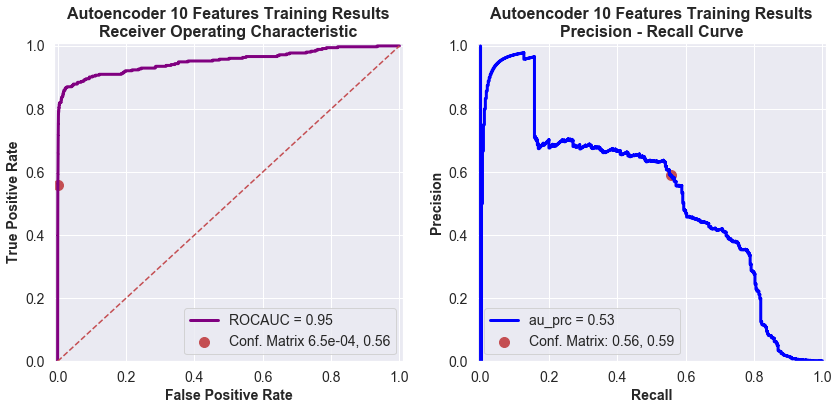

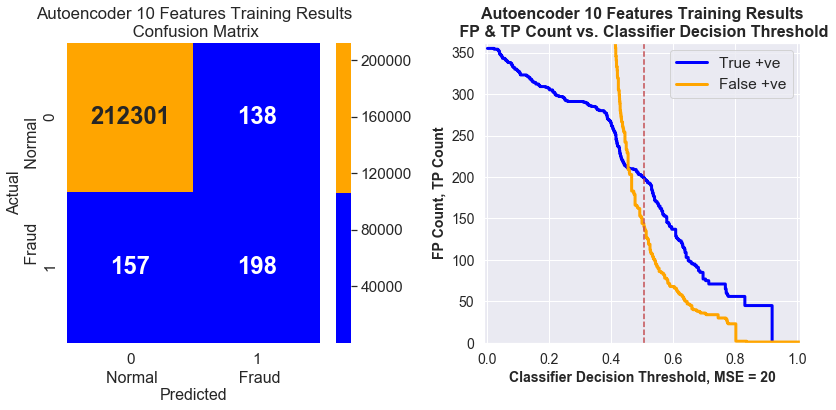

In [48]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs_10, y_train_preds_10 = Probs_preds('Autoencoder 10 Features Training Results', y_train_10, train_preds, Ptrs, Ntrs, 20)

### Now plot the ROC & PR Curves for the Test set. 

MSE Decision Threshold is:  20

Autoencoder 10 Features Test Set Results gives AU_PRC of 0.579and F1 Score of 0.575



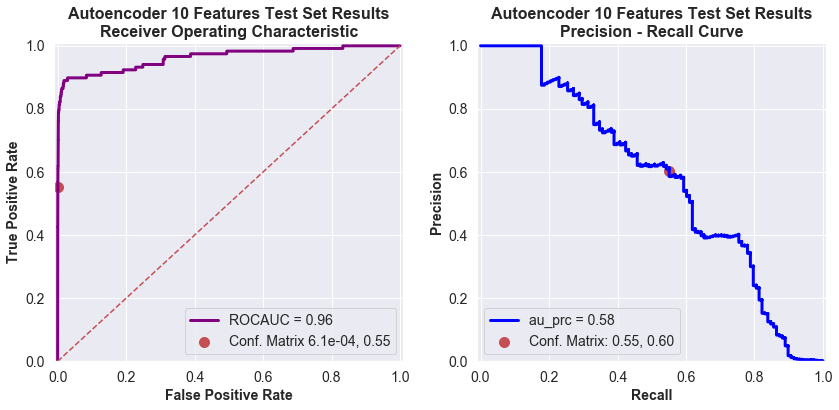

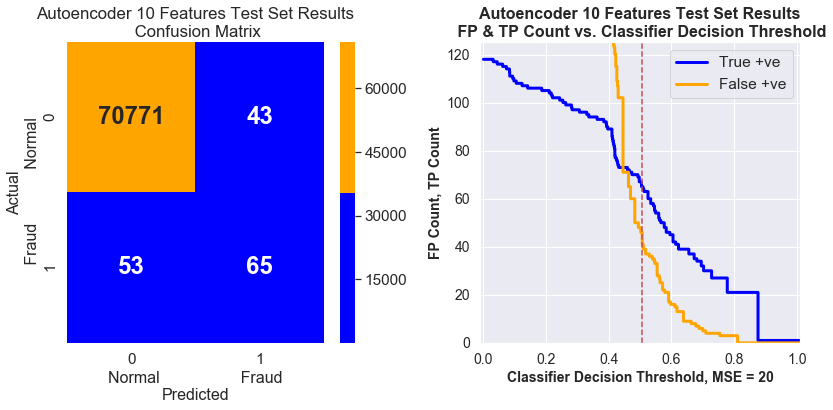

In [49]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs_10, y_test_preds_10 = Probs_preds('Autoencoder 10 Features Test Set Results', y_test_10, test_preds, Ps, Ns, 20)

#### The test set evaluation is slightly better than the training evaluation.  The performance may be better with fewer features that have a wider difference between normal and fraud.

### Plot performanceof amount of frauds identified, missed, & misclassified

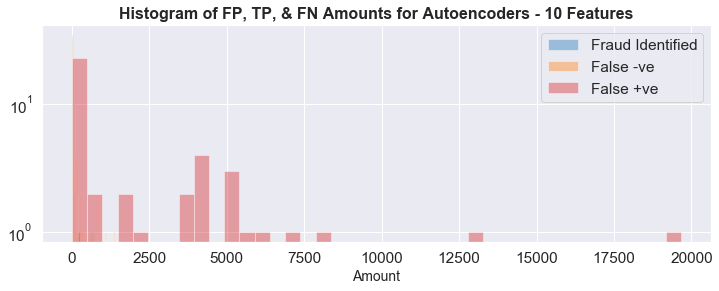

Fraud total identified is 5196.70,
Fraud total missed is 9130.19,
Normal total misclassified is 108013.47


In [50]:
Det_Amt_PLot('Autoencoders - 10 Features', Test_Set_10, y_test_10, y_test_preds_10)

### The model performance needs improvement.

## Try another model with 4 features both with and without the Amount feature.

In [51]:
# Drop features without 10* score over < 1
dfx_4 = dfx.drop(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v11','v13', 'v15', 'v16', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28'], axis = 1)
dfx_4.head()

v10       v12       v14       v17  amount
0  0.090794 -0.617801 -0.311169  0.207971  149.62
1 -0.166974  1.065235 -0.143772 -0.114805    2.69
2  0.207643  0.066084 -0.165946  1.109969  378.66
3 -0.054952  0.178228 -0.287924 -0.684093  123.50
4  0.753074  0.538196 -1.119670 -0.237033   69.99

In [52]:
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(dfx_4, y, stratify = y, test_size = 0.25, random_state = 6)

In [53]:
# Save a copy of train & test sets with amount before scaling to compare to measure performace against amount identified
Test_Set = x_test_4
Train_Set = x_train_4
x_train_4 =  x_train_4.iloc[:,0:5]
x_test_4 = x_test_4.iloc[:,0:5]
x_test_4[0:5][:]

v10       v12       v14       v17   amount
261092 -0.398150  0.873628 -1.169164  0.462084   150.00
101269 -0.563033  0.266429  1.311771 -0.130119     1.50
129533 -0.195106  0.084526  1.066976 -0.434841   696.00
79561  -0.207380 -0.537333  0.176618 -0.371017  1446.27
233338  0.159186  0.411452  0.033599 -0.640693    19.95

In [54]:
x_train_4 =  scaler.fit_transform(x_train_4)
x_test_4 = scaler.transform(x_test_4)

In [55]:
Ns, Ps = y_test_4.value_counts()
Ns, Ps, x_test_4.shape

(70814, 118, (70932, 5))

In [56]:
Ntrs, Ptrs = y_train_4.value_counts()
Ntrs, Ptrs, x_train_4.shape

(212439, 355, (212794, 5))

### Create Autoencoder model with 'elu' and 'nadam' as activation & optimizer functions.

In [57]:

activ = 'elu'
a = Input(shape=(5,))
b = Dense(3, activation = activ)(a)
c = Dense(2, activation = activ)(b)
d = Dense(3, activation = activ)(c)
Out = Dense(5, activation =activ)(d)
autoencoder4 = Model(inputs=a, outputs=Out)
autoencoder4.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [58]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Fit Model

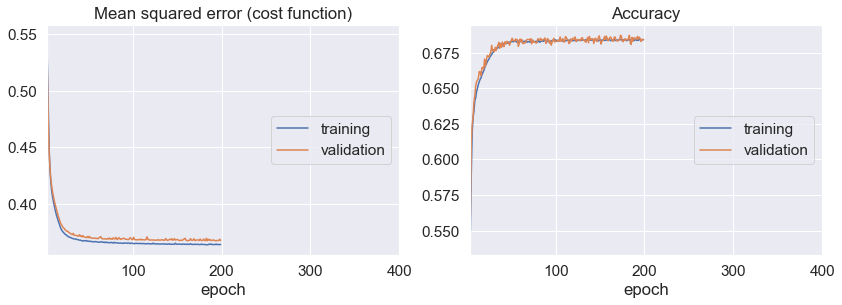

Mean squared error (cost function):
training   (min:    0.364, max:    0.833, cur:    0.364)
validation (min:    0.367, max:    0.658, cur:    0.368)

Accuracy:
training   (min:    0.297, max:    0.684, cur:    0.684)
validation (min:    0.492, max:    0.687, cur:    0.684)


In [59]:
#Fit the model, batch size, no. of epochs

autoencoder4.fit(x_train_4[y_train_4 ==0], x_train_4[y_train_4 ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

In [60]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_4', autoencoder4, x_train_4, y_train_4, x_test_4, y_test_4, Ps, Ns, 0)

### Plot Histogram and Scatter plot of sample MSE values (MSE of difference of original and reconstructed samples).

MSE stats for train set: min 0.0004, max 331.3780, mean 0.4652, std 4.2244


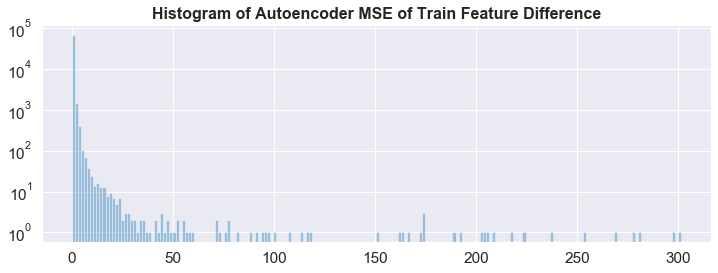

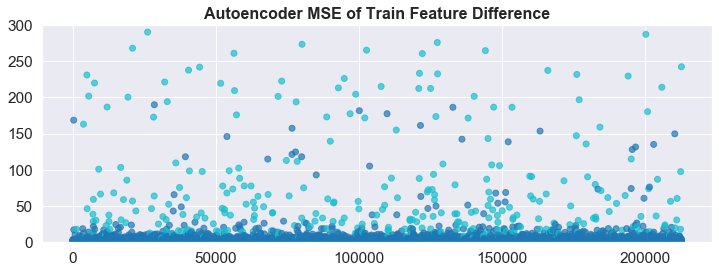

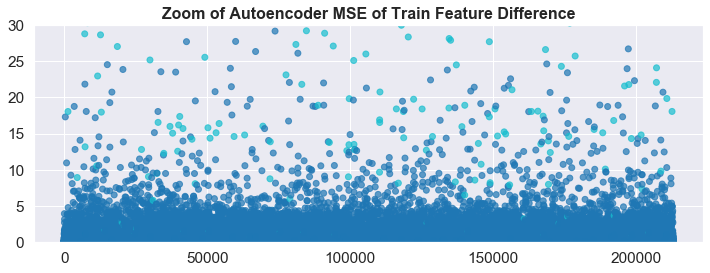

In [61]:
Train_Hist_Scatter(train_preds, y_train_4, _min[0], _max[0], _mean, _std, 300)

### Frauds are shown above in light blue.  Plot ROC P-R Curves etc. and use 19 as the MSE Threshold which corresponds to 50% using the probability Ln function converting MSE to probabilities.

MSE Decision Threshold is:  19

Autoencoder 4 Feature Training Results gives AU_PRC of 0.663and F1 Score of 0.670



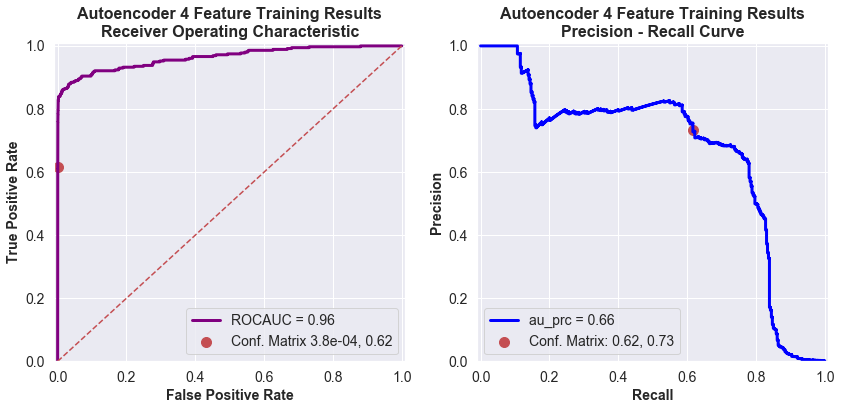

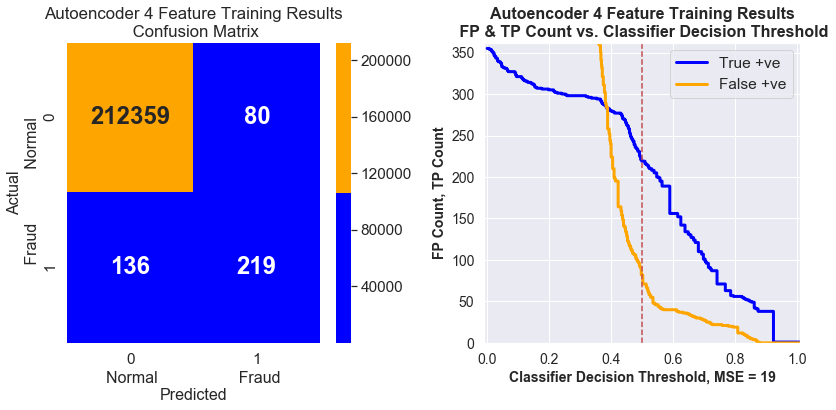

In [62]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs_4, y_train_preds_4 = Probs_preds('Autoencoder 4 Feature Training Results', y_train_4, train_preds, Ptrs, Ntrs, 19)

### Now plot the Test set data using 19 as the MSE threshold

MSE Decision Threshold is:  19

Autoencoder 4 Feature Test Set Results gives AU_PRC of 0.724and F1 Score of 0.706



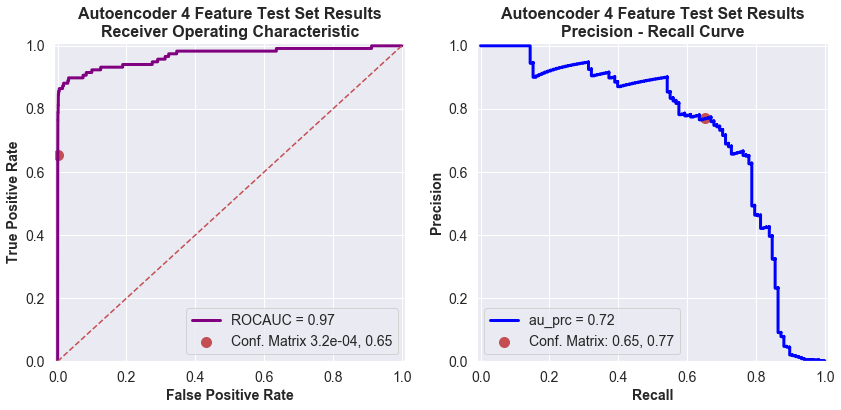

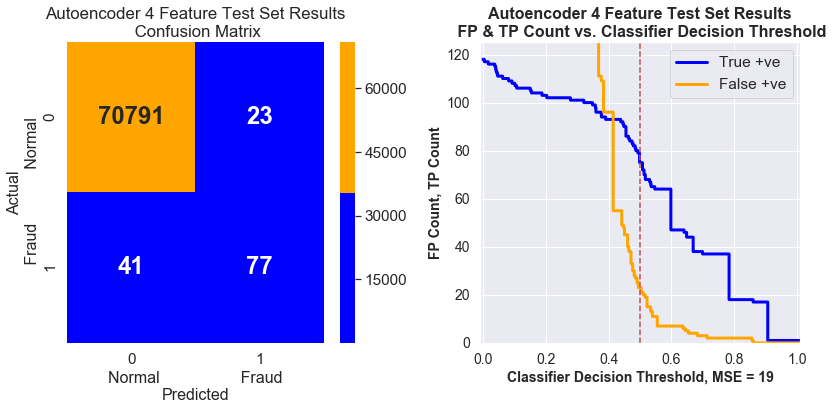

In [63]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs_4, y_test_preds_4 = Probs_preds('Autoencoder 4 Feature Test Set Results', y_test_4, test_preds, Ps, Ns, 19)

### Plot performanceof amount of frauds identified, missed, & misclassified.

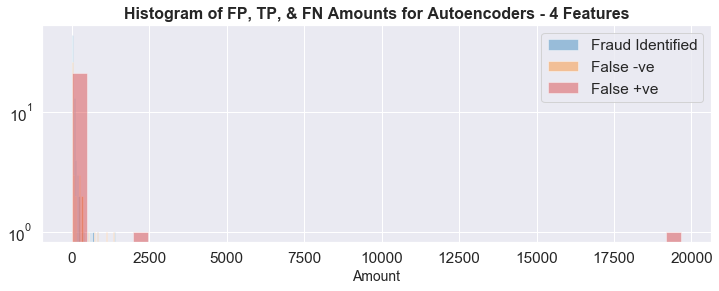

Fraud total identified is 7879.68,
Fraud total missed is 6447.21,
Normal total misclassified is 22560.46


In [64]:
Det_Amt_PLot('Autoencoders - 4 Features', Test_Set, y_test_4, y_test_preds_4)

## Performance is improving on the ROC & PR Curves, but the value amount needs improvement.  Next try dropping the Amount feature.

### Create a set with the same 4 features but without the Amount feature.

In [65]:
# Drop features without 10* score over < 1
dfx_4 = dfx.drop(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v11','v13', 'v15', 'v16', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28'], axis = 1)
dfx_4.head()

v10       v12       v14       v17  amount
0  0.090794 -0.617801 -0.311169  0.207971  149.62
1 -0.166974  1.065235 -0.143772 -0.114805    2.69
2  0.207643  0.066084 -0.165946  1.109969  378.66
3 -0.054952  0.178228 -0.287924 -0.684093  123.50
4  0.753074  0.538196 -1.119670 -0.237033   69.99

In [66]:
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(dfx_4, y, stratify = y, test_size = 0.25, random_state = 6)

In [67]:
# Save a copy of train & test sets with amount before scaling to compare to measure performace against amount identified
Test_Set = x_test_4
Train_Set = x_train_4
x_train_4 =  x_train_4.iloc[:,0:4]
x_test_4 = x_test_4.iloc[:,0:4]
x_test_4[0:5][:]

v10       v12       v14       v17
261092 -0.398150  0.873628 -1.169164  0.462084
101269 -0.563033  0.266429  1.311771 -0.130119
129533 -0.195106  0.084526  1.066976 -0.434841
79561  -0.207380 -0.537333  0.176618 -0.371017
233338  0.159186  0.411452  0.033599 -0.640693

In [68]:
x_train_4 =  scaler.fit_transform(x_train_4)
x_test_4 = scaler.transform(x_test_4)

In [69]:
Ns, Ps = y_test_4.value_counts()
Ns, Ps, x_test_4.shape

(70814, 118, (70932, 4))

In [70]:
Ntrs, Ptrs = y_train_4.value_counts()
Ntrs, Ptrs, x_train_4.shape

(212439, 355, (212794, 4))

## Create Autoencoder model again but with 4 feature input vs 5 (4 + amount).  Use the same activation & optimizer.

In [71]:

activ = 'elu'
a = Input(shape=(4,))
b = Dense(3, activation = activ)(a)
c = Dense(2, activation = activ)(b)
d = Dense(3, activation = activ)(c)
Out = Dense(4, activation =activ)(d)
autoencoder44 = Model(inputs=a, outputs=Out)
autoencoder44.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [72]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Fit Model

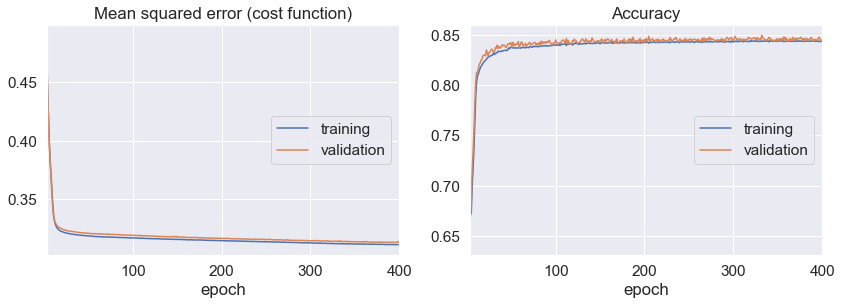

Mean squared error (cost function):
training   (min:    0.311, max:    0.742, cur:    0.311)
validation (min:    0.313, max:    0.689, cur:    0.314)

Accuracy:
training   (min:    0.392, max:    0.845, cur:    0.844)
validation (min:    0.476, max:    0.850, cur:    0.845)


In [73]:
#Fit the model, batch size, no. of epochs

autoencoder44.fit(x_train_4[y_train_4 ==0], x_train_4[y_train_4 ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

In [74]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_4', autoencoder44, x_train_4, y_train_4, x_test_4, y_test_4, Ps, Ns, 0)

### Plot Histogram and Scatter plot of sample MSE values (MSE of difference of original and reconstructed samples).

MSE stats for train set: min 0.0001, max 368.4981, mean 0.4359, std 5.2203


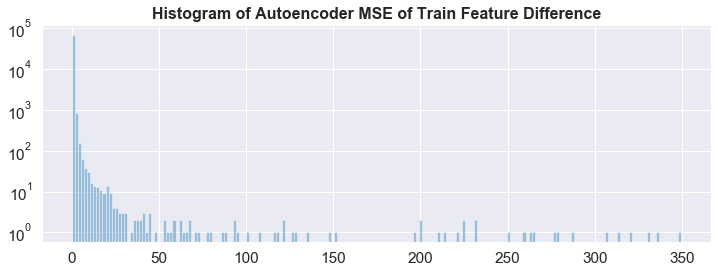

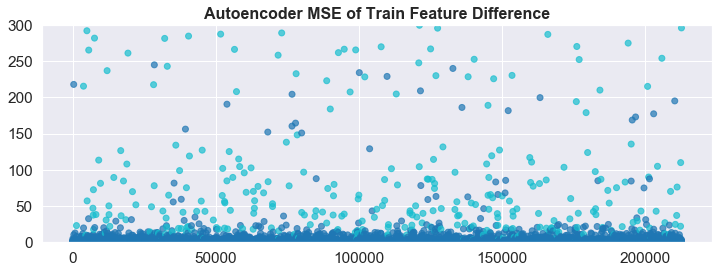

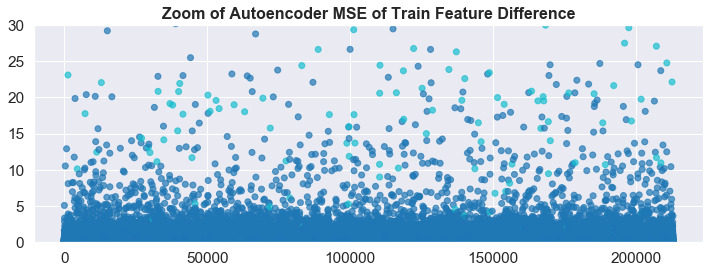

In [75]:
Train_Hist_Scatter(train_preds, y_train_4, _min[0], _max[0], _mean, _std, 300)

### Frauds are shown above in light blue.  Use 19 again as the MSE threshold.

MSE Decision Threshold is:  19

Autoencoder 4 Feature (No Amount) Training Results gives AU_PRC of 0.662and F1 Score of 0.706



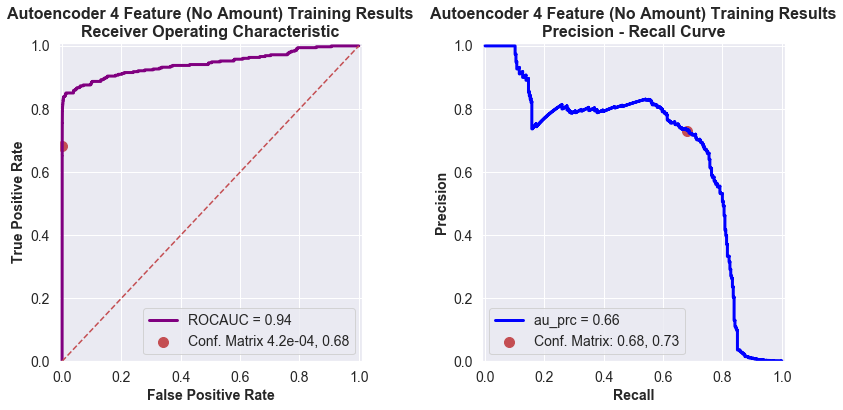

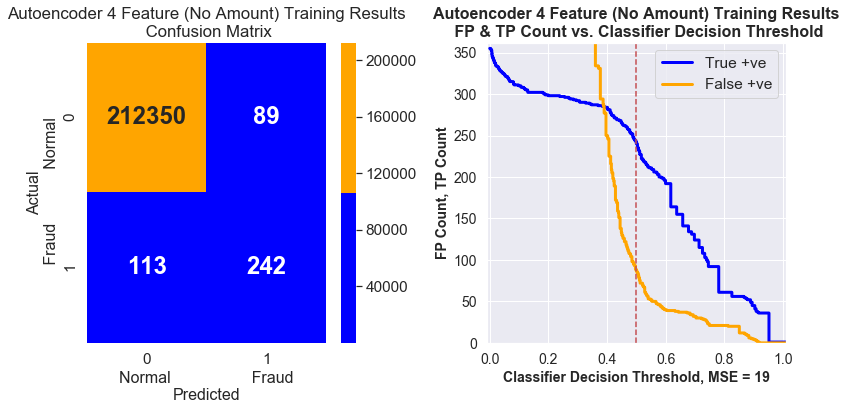

In [76]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs_4, y_train_preds_4 = Probs_preds('Autoencoder 4 Feature (No Amount) Training Results', y_train_4, train_preds, Ptrs, Ntrs, 19)

### Now plot the Test Set reults: 4 Features, without Amount.

MSE Decision Threshold is:  19

Autoencoder 4 Feature (No Amount) Test Set Results gives AU_PRC of 0.723and F1 Score of 0.707



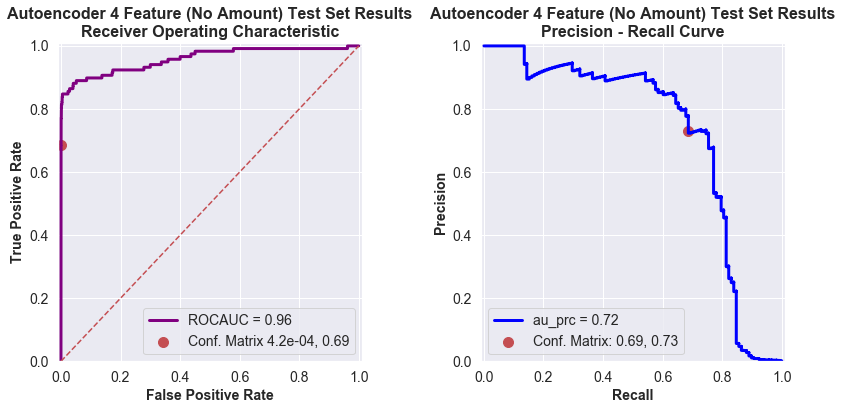

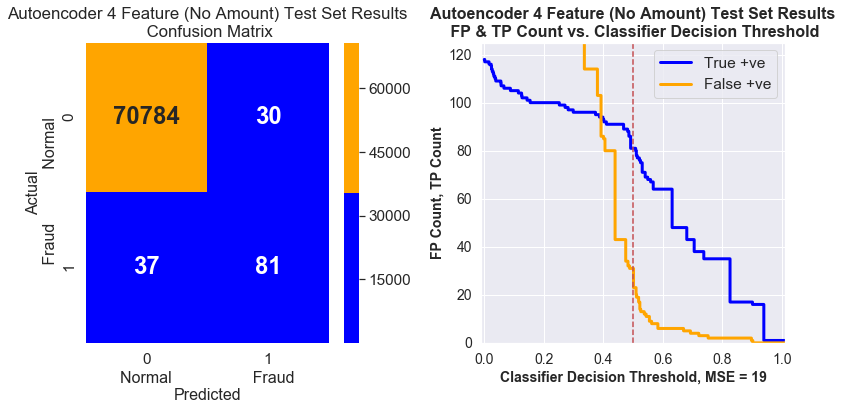

In [77]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs_4, y_test_preds_4 = Probs_preds('Autoencoder 4 Feature (No Amount) Test Set Results', y_test_4, test_preds, Ps, Ns, 19)

### Plot performanceof amount of frauds identified, missed, & misclassified.

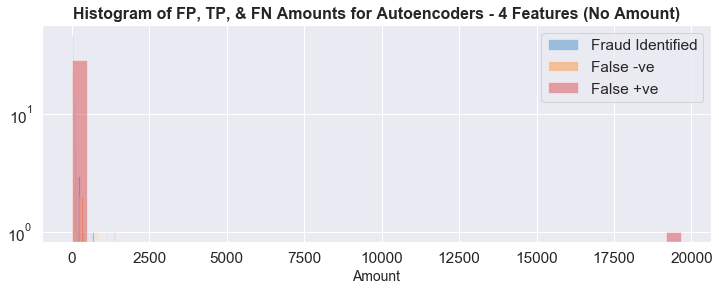

Fraud total identified is 7453.09,
Fraud total missed is 6873.80,
Normal total misclassified is 20850.47


In [78]:
Det_Amt_PLot('Autoencoders - 4 Features (No Amount)', Test_Set, y_test_4, y_test_preds_4)

## The model performance is much better overall with 4 features. Next try 3 features plus amount and 3 features without amount.

In [79]:
# Drop features without 10* score over < 1
dfx_3 = dfx.drop(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v11', 'v12', 'v13', 'v15', 'v16', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28'], axis = 1)
dfx_3.head()

v10       v14       v17  amount
0  0.090794 -0.311169  0.207971  149.62
1 -0.166974 -0.143772 -0.114805    2.69
2  0.207643 -0.165946  1.109969  378.66
3 -0.054952 -0.287924 -0.684093  123.50
4  0.753074 -1.119670 -0.237033   69.99

In [80]:
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(dfx_3, y, stratify = y, test_size = 0.25, random_state = 6)

In [81]:
# Save a copy of train & test sets with amount before scaling to compare to measure performace against amount identified
Test_Set = x_test_3
Train_Set = x_train_3
x_train_3 =  x_train_3.iloc[:,0:4]
x_test_3 = x_test_3.iloc[:,0:4]
x_test_3[0:5][:]

v10       v14       v17   amount
261092 -0.398150 -1.169164  0.462084   150.00
101269 -0.563033  1.311771 -0.130119     1.50
129533 -0.195106  1.066976 -0.434841   696.00
79561  -0.207380  0.176618 -0.371017  1446.27
233338  0.159186  0.033599 -0.640693    19.95

In [82]:
x_train_3 =  scaler.fit_transform(x_train_3)
x_test_3 = scaler.transform(x_test_3)

In [83]:
Ns, Ps = y_test_3.value_counts()
Ns, Ps, x_test_3.shape

(70814, 118, (70932, 4))

In [84]:
Ntrs, Ptrs = y_train_3.value_counts()
Ntrs, Ptrs, x_train_3.shape

(212439, 355, (212794, 4))

In [85]:

activ = 'elu'
a = Input(shape=(4,))
b = Dense(3, activation = activ)(a)
c = Dense(2, activation = activ)(b)
d = Dense(3, activation = activ)(c)
Out = Dense(4, activation =activ)(d)
autoencoder3 = Model(inputs=a, outputs=Out)
autoencoder3.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [86]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Fit Model

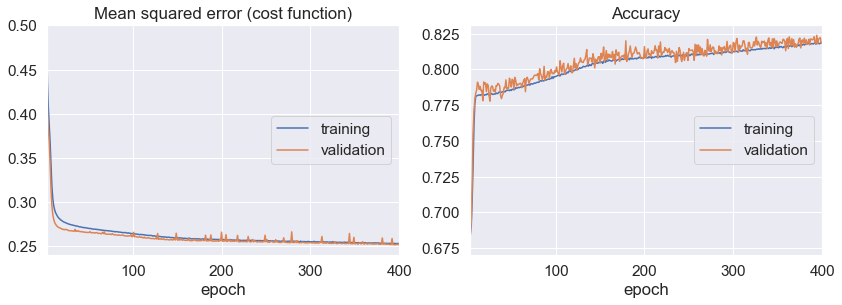

Mean squared error (cost function):
training   (min:    0.253, max:    0.748, cur:    0.253)
validation (min:    0.252, max:    0.600, cur:    0.252)

Accuracy:
training   (min:    0.519, max:    0.819, cur:    0.819)
validation (min:    0.605, max:    0.824, cur:    0.819)


In [87]:
#Fit the model, batch size, no. of epochs

autoencoder3.fit(x_train_3[y_train_3 ==0], x_train_3[y_train_3 ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

In [88]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_3', autoencoder3, x_train_3, y_train_3, x_test_3, y_test_3, Ps, Ns, 0)

### Plot Histogram and Scatter plot of sample MSE values (MSE of difference of original and reconstructed samples).

MSE stats for train set: min 0.0000, max 349.8239, mean 0.3510, std 4.1755


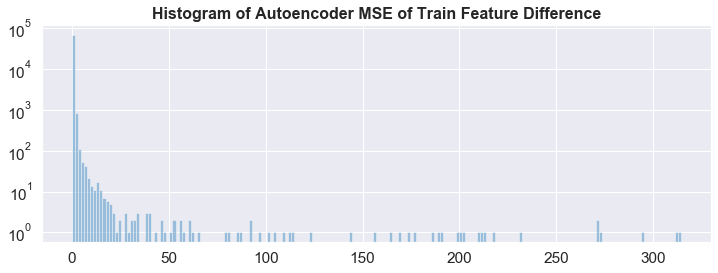

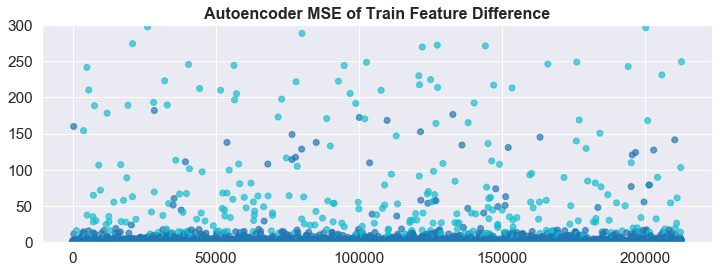

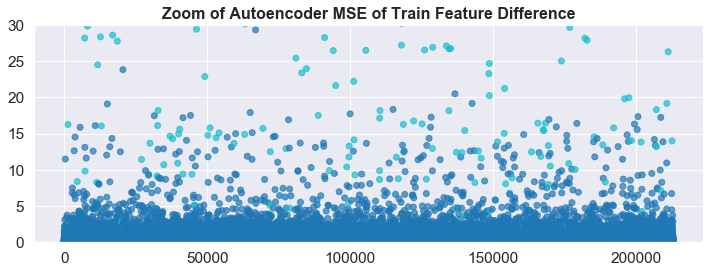

In [89]:
Train_Hist_Scatter(train_preds, y_train_3, _min[0], _max[0], _mean, _std, 300)

### Frauds are shown above in light blue.

MSE Decision Threshold is:  25

Autoencoder 3 Feature Training Results gives AU_PRC of 0.670and F1 Score of 0.660



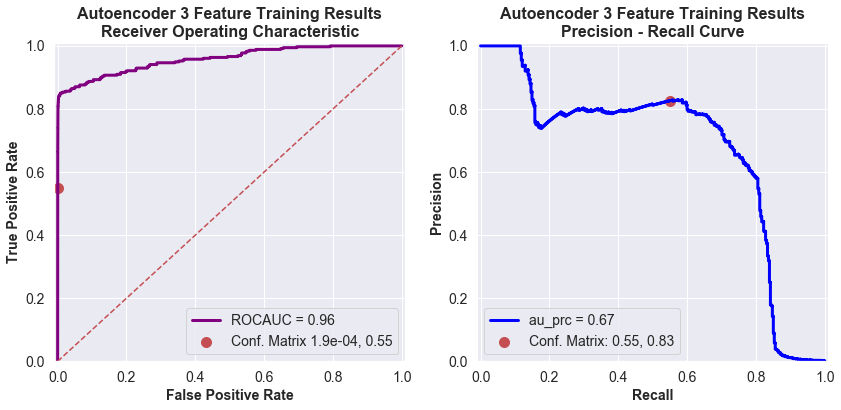

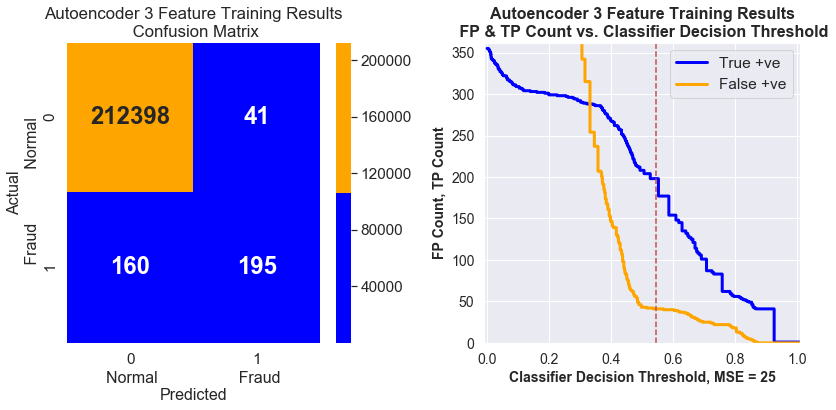

In [90]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs_3, y_train_preds_3 = Probs_preds('Autoencoder 3 Feature Training Results', y_train_3, train_preds, Ptrs, Ntrs, 25)

### PLot the results on the Test set.

MSE Decision Threshold is:  25

Autoencoder 3 Feature Test Set Results gives AU_PRC of 0.740and F1 Score of 0.638



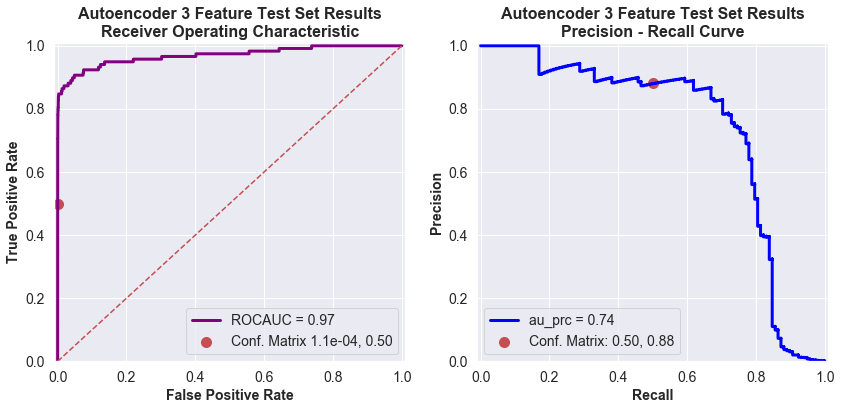

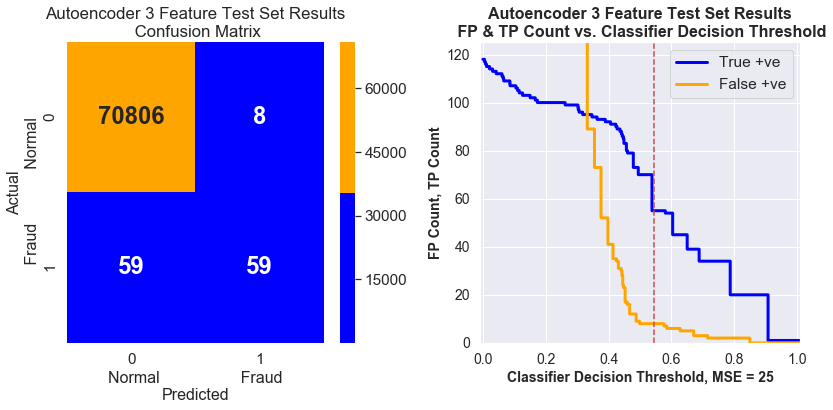

In [91]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs_3, y_test_preds_3 = Probs_preds('Autoencoder 3 Feature Test Set Results', y_test_3, test_preds, Ps, Ns, 25)

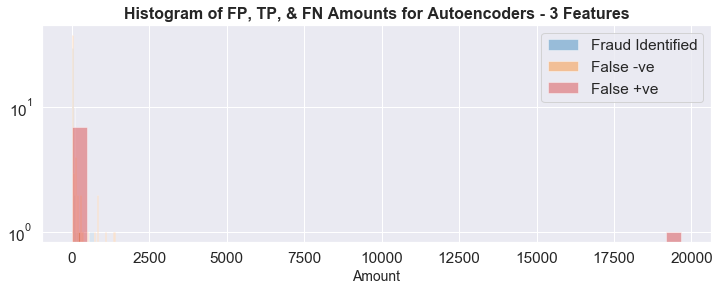

Fraud total identified is 5005.81,
Fraud total missed is 9321.08,
Normal total misclassified is 20019.49


In [92]:
Det_Amt_PLot('Autoencoders - 3 Features', Test_Set, y_test_3, y_test_preds_3)

### The model is picking up some higher value false positives.  Now try dropping amount.

In [93]:
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(dfx_3, y, stratify = y, test_size = 0.25, random_state = 6)

In [94]:
# Save a copy of train & test sets with amount before scaling to compare to measure performace against amount identified
Test_Set = x_test_3
Train_Set = x_train_3
x_train_3 =  x_train_3.iloc[:,0:3]
x_test_3 = x_test_3.iloc[:,0:3]
x_test_3[0:5][:]

v10       v14       v17
261092 -0.398150 -1.169164  0.462084
101269 -0.563033  1.311771 -0.130119
129533 -0.195106  1.066976 -0.434841
79561  -0.207380  0.176618 -0.371017
233338  0.159186  0.033599 -0.640693

In [95]:
x_train_3 =  scaler.fit_transform(x_train_3)
x_test_3 = scaler.transform(x_test_3)

In [96]:
Ns, Ps = y_test_3.value_counts()
Ns, Ps, x_test_3.shape

(70814, 118, (70932, 3))

In [97]:
Ntrs, Ptrs = y_train_3.value_counts()
Ntrs, Ptrs, x_train_3.shape

(212439, 355, (212794, 3))

In [98]:

activ = 'elu'
a = Input(shape=(3,))
b = Dense(2, activation = activ)(a)
c = Dense(2, activation = activ)(b)
Out = Dense(3, activation =activ)(c)
autoencoder33 = Model(inputs=a, outputs=Out)
autoencoder33.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [99]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Fit Model

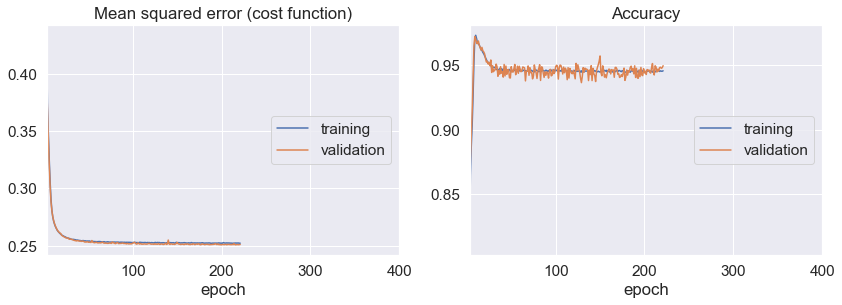

Mean squared error (cost function):
training   (min:    0.252, max:    0.870, cur:    0.252)
validation (min:    0.251, max:    0.719, cur:    0.251)

Accuracy:
training   (min:    0.498, max:    0.974, cur:    0.946)
validation (min:    0.585, max:    0.973, cur:    0.950)


In [100]:
#Fit the model, batch size, no. of epochs

autoencoder33.fit(x_train_3[y_train_3 ==0], x_train_3[y_train_3 ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

In [101]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_3', autoencoder33, x_train_3, y_train_3, x_test_3, y_test_3, Ps, Ns, 0)

### Plot Histogram and Scatter plot of sample MSE values (MSE of difference of original and reconstructed samples).

MSE stats for train set: min 0.0000, max 463.6844, mean 0.3932, std 5.8874


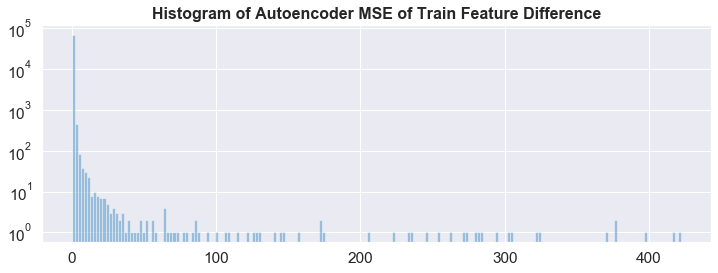

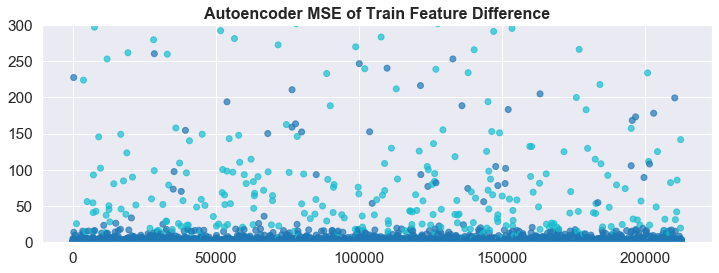

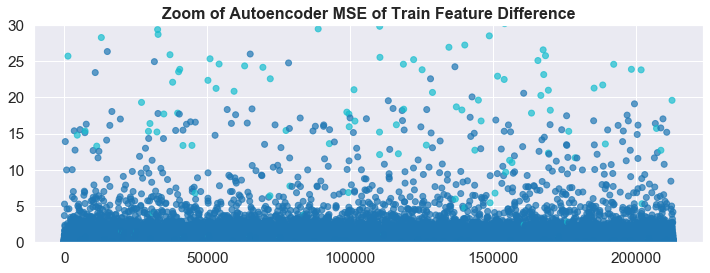

In [102]:
Train_Hist_Scatter(train_preds, y_train_3, _min[0], _max[0], _mean, _std, 300)

### Frauds are shown above in light blue.

MSE Decision Threshold is:  19

Autoencoder 3 Feature (No Amount) Training Results gives AU_PRC of 0.690and F1 Score of 0.763



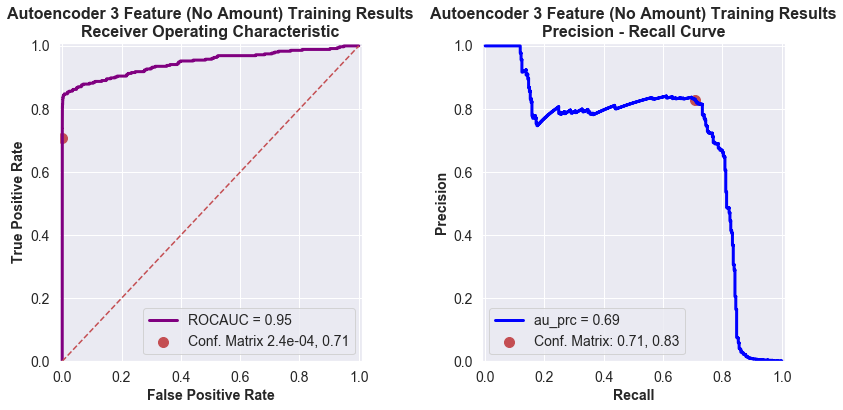

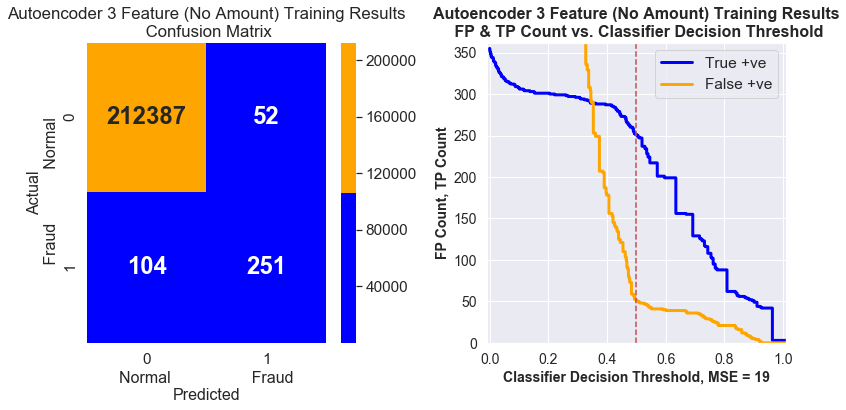

In [103]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs_3, y_train_preds_3 = Probs_preds('Autoencoder 3 Feature (No Amount) Training Results', y_train_3, train_preds, Ptrs, Ntrs, 19)

### Now Plot the Test set results.

MSE Decision Threshold is:  19

Autoencoder 3 Feature(No Amount) Test Set Results gives AU_PRC of 0.763and F1 Score of 0.813



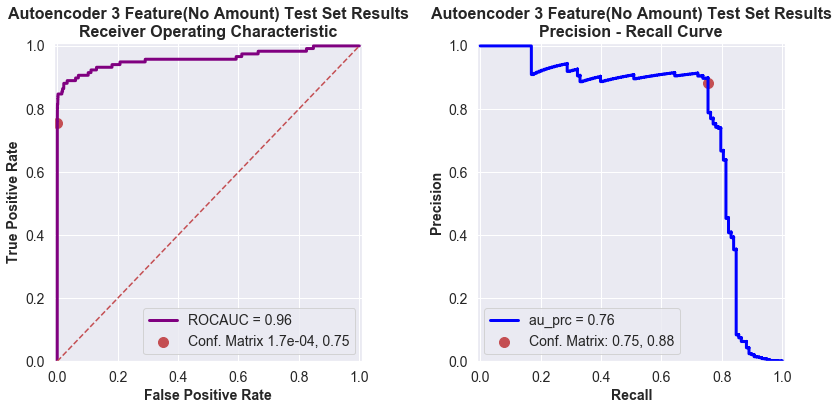

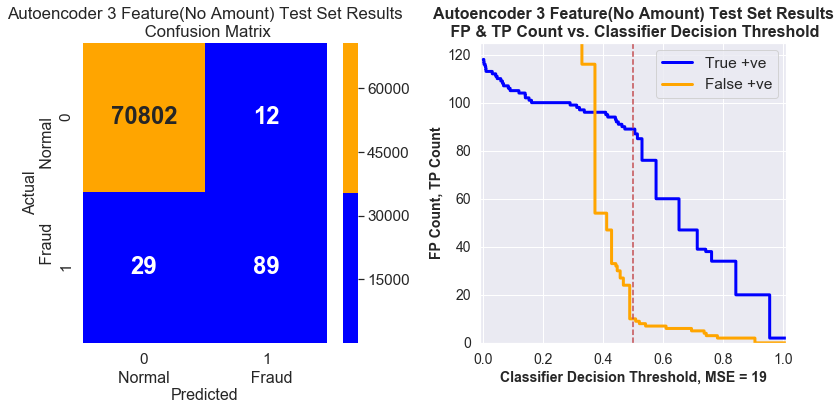

In [104]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs_3, y_test_preds_3 = Probs_preds('Autoencoder 3 Feature(No Amount) Test Set Results', y_test_3, test_preds, Ps, Ns, 19)

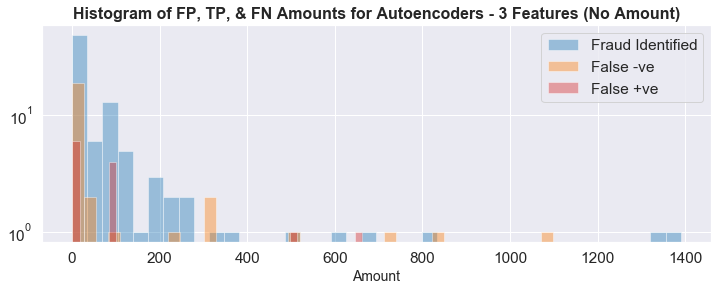

Fraud total identified is 10032.37,
Fraud total missed is 4294.52,
Normal total misclassified is 1535.28


In [105]:
Det_Amt_PLot('Autoencoders - 3 Features (No Amount)', Test_Set, y_test_3, y_test_preds_3)

## Performance did improve slightly with 3 features over 4 features but the false positive value amount also increased.  Try multiple Choke points staying with 3 features.

In [106]:

activ = 'elu'
a = Input(shape=(3,))
b = Dense(2, activation = activ)(a)
c = Dense(3, activation = activ)(b)
d = Dense(4, activation = activ)(c)
e = Dense(3, activation = activ)(d)
f = Dense(2, activation = activ)(e)
Out = Dense(3, activation =activ)(f)
autoencoder333 = Model(inputs=a, outputs=Out)
autoencoder333.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [107]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=15, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# Fit Model

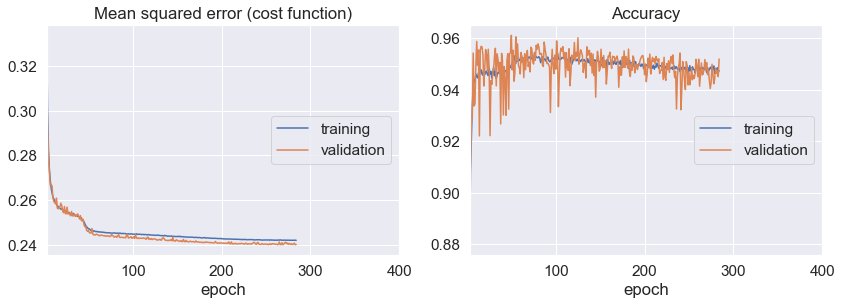

Mean squared error (cost function):
training   (min:    0.242, max:    0.601, cur:    0.242)
validation (min:    0.240, max:    0.426, cur:    0.240)

Accuracy:
training   (min:    0.595, max:    0.954, cur:    0.947)
validation (min:    0.807, max:    0.961, cur:    0.952)


In [108]:
#Fit the model, batch size, no. of epochs

autoencoder333.fit(x_train_3[y_train_3 ==0], x_train_3[y_train_3 ==0], validation_split=0.2, callbacks = [live_plot, early_stop], batch_size = 1024, initial_epoch=0, epochs = 400, verbose = 1)

In [109]:
# Get MSE predictions & stats on train & test
train_preds, test_preds, _min , _max, _mean, _std = AE_preds('Autoencoder_3', autoencoder333, x_train_3, y_train_3, x_test_3, y_test_3, Ps, Ns, 0)

### Plot Histogram and Scatter plot of sample MSE values (MSE of difference of original and reconstructed samples).

MSE stats for train set: min 0.0000, max 453.1009, mean 0.3853, std 5.9045


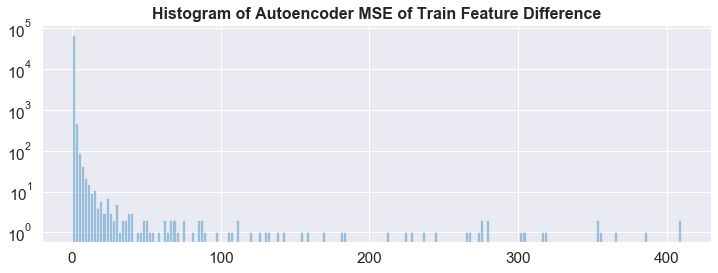

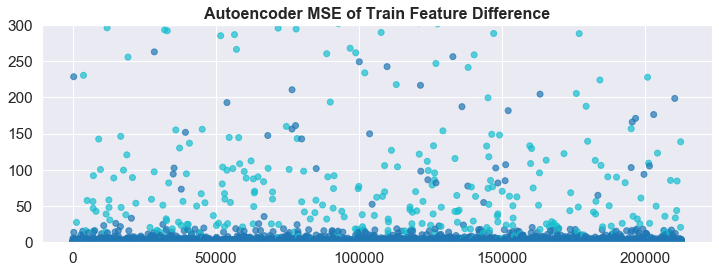

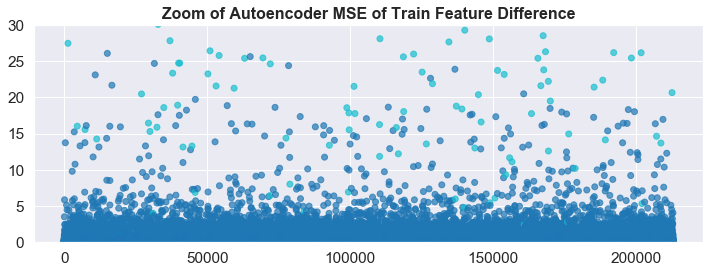

In [110]:
Train_Hist_Scatter(train_preds, y_train_3, _min[0], _max[0], _mean, _std, 300)

### Frauds are shown above in light blue.

MSE Decision Threshold is:  19

Autoencoder 3 Feature Training Results gives AU_PRC of 0.695and F1 Score of 0.766



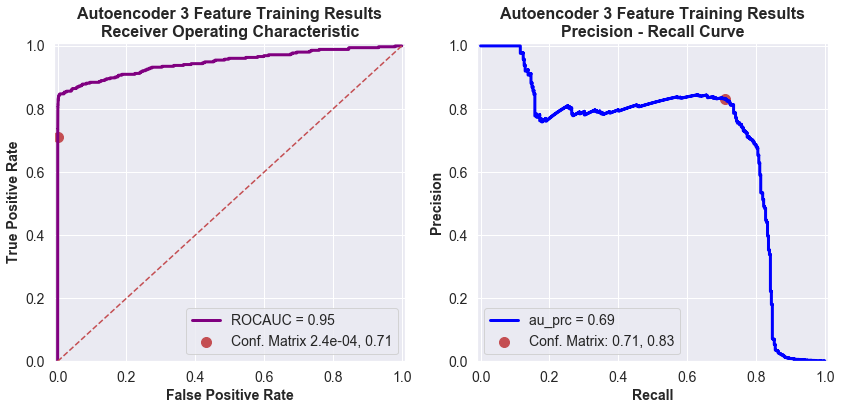

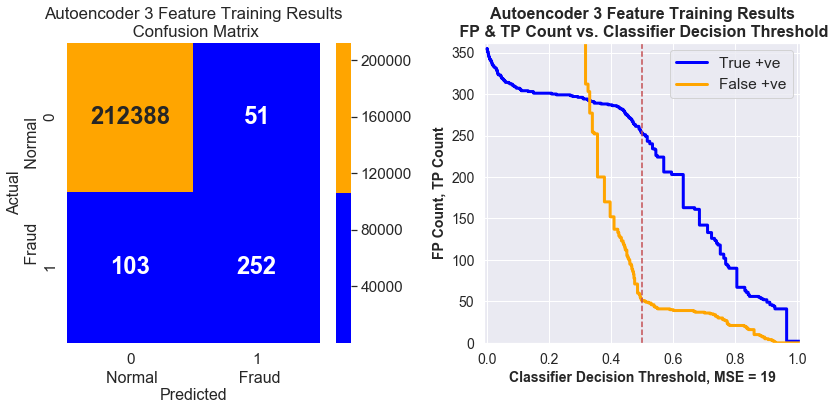

In [111]:
# Get probability prediction values for samples and plot results - Training Set
y_train_probs_3, y_train_preds_3 = Probs_preds('Autoencoder 3 Feature Training Results', y_train_3, train_preds, Ptrs, Ntrs,19)

### Now plot the Test set results.

MSE Decision Threshold is:  19

Autoencoder 3 Feature Test Set Results gives AU_PRC of 0.766and F1 Score of 0.817



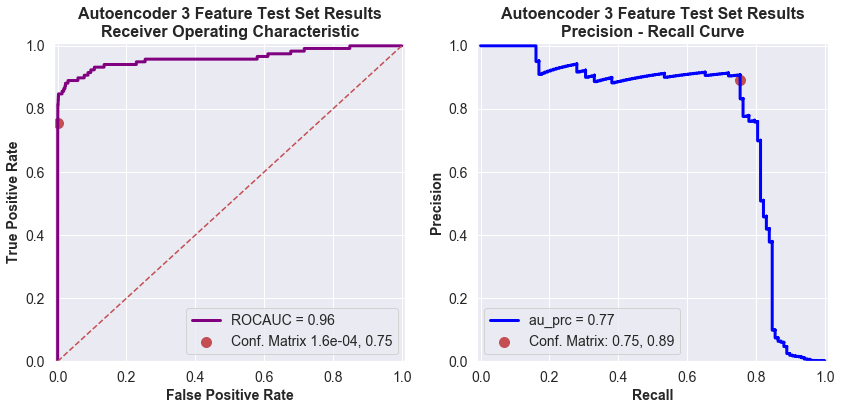

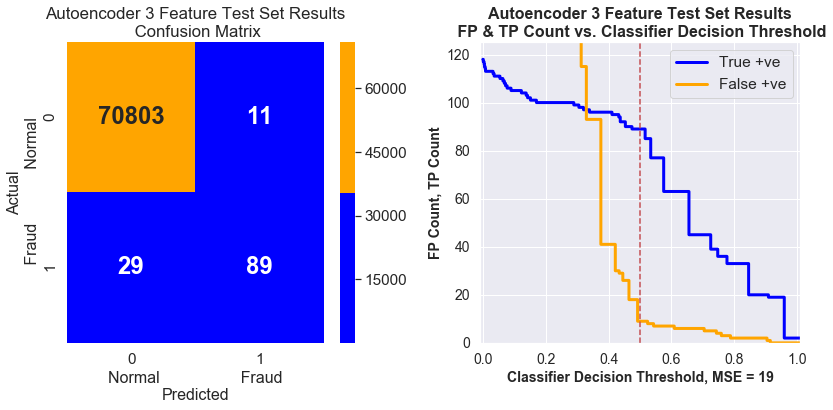

In [112]:
# Get probability prediction values for samples and plot results - Test Set
y_test_probs_3, y_test_preds_3 = Probs_preds('Autoencoder 3 Feature Test Set Results', y_test_3, test_preds, Ps, Ns, 19)

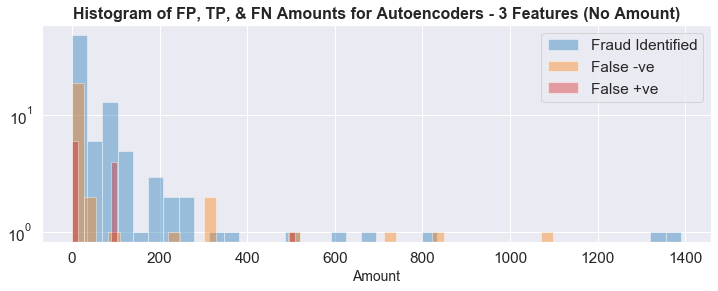

Fraud total identified is 10032.37,
Fraud total missed is 4294.52,
Normal total misclassified is 874.01


In [113]:
Det_Amt_PLot('Autoencoders - 3 Features (No Amount)', Test_Set, y_test_3, y_test_preds_3)

## Using a multiple gate improved the AU-PRC & F1 score marginally but did lower the false positive value by 665 (about 43%) .

### The P-R Curve below is plotted to demonstrate that the MSE scores will give the same curve as the derived probability score.  Thae FP & TP vs. Threshold will also plot the same but with a wider range of MSE scores from o to over 400.

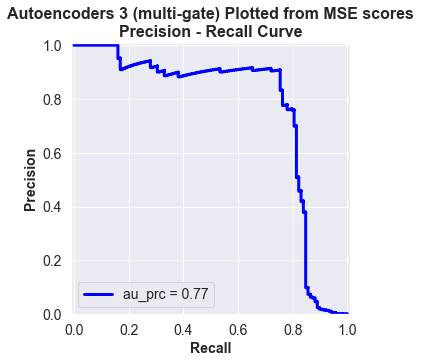

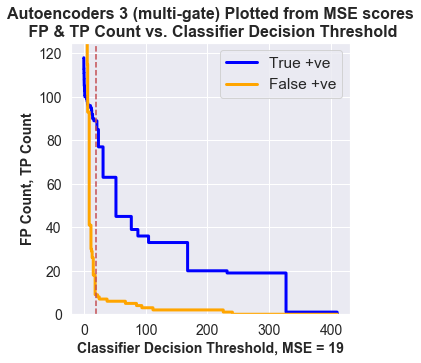

In [123]:
# y_test_3 is the target, test_preds is the calculated MSE value between the x_test_3 sample feature valuesand the model reconstructed feature values.

precision_, recall_, _ = precision_recall_curve(y_test_3, test_preds) #test_preds are the MSE scores for the test samples
AP = average_precision_score(y_test_3, test_preds)
plt.figure(figsize=(5,5))    
plt.title((('{}\nPrecision - Recall Curve').format('Autoencoders 3 (multi-gate) Plotted from MSE scores')), weight = 'bold', fontsize = 16)
plt.step(recall_, precision_, 'blue', lw = '3', where = 'pre', label='au_prc = %0.2f'% AP)

plt.legend(loc='lower left', fontsize = 14)
plt.xlim([-0.01,1.01])
plt.ylim([-0.0,1.01])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('Precision', weight = 'bold', fontsize = 14)
plt.xlabel('Recall', weight = 'bold', fontsize = 14)
plt.grid('black')
plt.show()

# PLot FP & TP Count vs MSE Score
fpr_MSE, tpr_MSE, thresholds_MSE = roc_curve(y_test_3, test_preds)
plt.figure(figsize=(5,5))
plt.step(thresholds_MSE, tpr_MSE*P, c='blue', lw = '3', where = 'mid', label = 'True +ve')
plt.step(thresholds_MSE, fpr_MSE*N, c='orange', lw = '3', where = 'mid', label = 'False +ve')
plt.plot([19,19],[0,125], 'r--')
plt.ylim(-0.01, 125)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(('{}\n FP & TP Count vs. Classifier Decision Threshold').format('Autoencoders 3 (multi-gate) Plotted from MSE scores'), weight = 'bold', fontsize = 16)
plt.ylabel('FP Count, TP Count', weight = 'bold', fontsize=14)
plt.xlabel(('Classifier Decision Threshold, MSE = {}').format(19), weight = 'bold', fontsize=14)
plt.legend()
plt.grid('black')
plt.show()

## Investigate using Autoencoders as part of a hybrid classifier taking the encoded layer results and training that on Random Forest.  Or investigate a different mix of features for the 4 or 3 feature runs.  The feature importance for Random Forest may not different than the best mix of features for autoencoders.